(cifar10-resnet18-relu)=
# Cifar10 上的 ReNet18

本文主要介绍在 cifar10 的试验 resnet18 的性能。

导入一些必要包：

In [1]:
import logging
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.vision.classifier import Classifier, evaluate_accuracy
from torch_book.datasets.cifar10 import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存


logging.basicConfig(filename='logs/debug-graph.log',
                    filemode="w",
                    format='%(asctime)s|%(levelname)s|%(name)s->%(funcName)s@%(message)s',
                    level=logging.INFO)

{mod}`torchvision` 上的 ResNet18 直接用于 cifar10 是不推荐的。需要做以下改动：

```{note}
将 `conv1` 替换以支持 $32 \times 32$ 的输入。同时移除第一个 `maxpool` 避免图片信息过早丢失。
```

In [2]:
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels, 
                        model.conv1.out_channels,
                        3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)

加载数据集：

In [3]:
data = Cifar10(batch_size = 128, num_workers=8, cutout=None)
train_iter = data.train_loader()
test_iter = data.val_loader()

Files already downloaded and verified
Files already downloaded and verified


打印每层输出尺寸：

In [4]:
for xs, _ in train_iter:
    break

for name, m in model.named_children():
    xs = m(xs)
    print(name, tuple(xs.shape))
    if name=="avgpool":
        xs = torch.flatten(xs, 1)

conv1 (128, 64, 32, 32)
bn1 (128, 64, 32, 32)
relu (128, 64, 32, 32)
maxpool (128, 64, 32, 32)
layer1 (128, 64, 32, 32)
layer2 (128, 128, 16, 16)
layer3 (128, 256, 8, 8)
layer4 (128, 512, 4, 4)
avgpool (128, 512, 1, 1)
fc (128, 10)


做一些准备工作：

In [5]:
classifier = Classifier(model, train_iter, test_iter, device=torch.device("cuda:0"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)

训练模型：

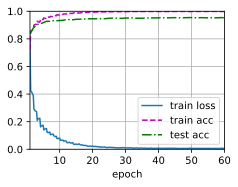

In [6]:
torch._dynamo.reset()
num_epochs = 60
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

In [7]:
test_acc = evaluate_accuracy(classifier.mod, classifier.test_iter, device=torch.device("cuda:0"))
test_acc

0.9529

保存模型（也可以直接 {download}`下载训练权重 <https://github.com/xinetzone/torch-book/releases/download/resnet18_cifar10_relu/resnet18_cifar10_relu.h5>`）：

In [8]:
torch.save(classifier.mod.state_dict(),
           'params/resnet18_cifar10_relu.h5')

## Cutout Cifar10 训练

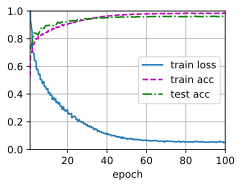

In [9]:
import logging
import torch
from torch import nn
from torchvision.models import resnet18, ResNet18_Weights
from torch_book.vision.classifier import Classifier, evaluate_accuracy
from torch_book.datasets.cifar10 import Cifar10
torch.cuda.empty_cache() # 清空 GPU 缓存
from torch_book.transforms.cutout import Cutout


logging.basicConfig(filename='logs/debug-graph.log',
                    filemode="a",
                    format='%(asctime)s|%(levelname)s|%(name)s->%(funcName)s@%(message)s',
                    level=logging.INFO)

num_epochs = 100
model = resnet18(weights=ResNet18_Weights.DEFAULT)
model.conv1 = nn.Conv2d(model.conv1.in_channels,
                        model.conv1.out_channels,
                        3, 1, 1, bias=False)
model.maxpool = nn.Identity()
model.fc = nn.Linear(model.fc.in_features, 10)
data = Cifar10(batch_size = 32, cutout=Cutout(1, 16), num_workers=8)
train_iter = data.train_loader()
test_iter = data.val_loader()
classifier = Classifier(model, train_iter, test_iter, device=torch.device("cuda:0"))
classifier.prepare_optimizer(lr=0.0142857, momentum=0.857142,
                             weight_decay=0.000857142)
classifier.prepare_scheduler(lr_period=2, lr_decay=0.857142)
classifier.prepare_animator(num_epochs)
classifier.fit(num_epochs)

In [10]:
test_acc = evaluate_accuracy(classifier.mod, classifier.test_iter, device=torch.device("cuda:0"))
test_acc

0.9601

In [11]:
torch.save(classifier.mod.state_dict(),
           'params/resnet18_cifar10_relu_cutout.h5')

## 性能度量

In [12]:
from torch.profiler import profile, record_function, ProfilerActivity
inputs = torch.randn(5, 3, 32, 32).type(torch.float32).cuda()       
with profile(activities=[ProfilerActivity.CPU, 
                         ProfilerActivity.CUDA], 
             record_shapes=True) as prof:
    with record_function("model_inference"):
        classifier.mod(inputs)
print(prof.key_averages().table(sort_by="cuda_time_total", row_limit=10))

STAGE:2023-11-22 11:06:07 3079502:3079502 ActivityProfilerController.cpp:312] Completed Stage: Warm Up
STAGE:2023-11-22 11:06:07 3079502:3079502 ActivityProfilerController.cpp:318] Completed Stage: Collection
STAGE:2023-11-22 11:06:07 3079502:3079502 ActivityProfilerController.cpp:322] Completed Stage: Post Processing


-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                        model_inference         3.55%       2.243ms        99.77%      63.060ms      63.060ms       0.000us         0.00%       1.294ms       1.294ms             1  
                                           aten::conv2d         0.13%      84.000us        90.74%      57.355ms       2.868ms       0.000us         0.00%       1.202ms      60.100us            20  
         